# Analysing Meerkat Data

Gunnar Ro

## Plan

1. Overview over data in Meerkat project and how it is processed
2. How to access data
    1. Raw Data
    2. Download data
    3. APIs
3. Using python to access and analyse data
    1. Pandas and analysing CSV / Excel files
    2. Getting data from API
    3. Very brief overview of Python tools to visualise and analyse data

## Meerkat Data

### Sources
* Forms
    * Case Report
    * Daily Register
    * Invesitgation and central review
    * Foreigner Screening
    * ...
* Tablet Inventory
    * Population
    * GIS
    * Names
* Meerkat Logs

## Forms

Pretty familar with how data collection works by now

Each entered form -> "One row" in DB or in CSV file

To make useful we need to combine it with tablet inventory data and process it

## Data proccessing pipeline

1. Form is submitted 
2. Submission is exported from MOH/RMS server to meerkat online framework
3. Submission is matched to clinic using deviceid. Clinic gives population, gps etc
4. Submission is Quality Controlled
    1. Training data is removed
    2. Unphysical values are removed
    3. Duplicated new visits are fixed
5. Raw data is proccesses into "proccessed" data based on defined codes/variables



![Data Processing](data_processing.png)

## Accessing Data for Analysis

1. Raw Data
    * The raw data anonymised data exported from servers can be avilable as csv files or in the future in Postgresql
2. Download Data
    * Specified Data sets are avilable for downloading using the online portal as excel/csv files
3. Data tables 
    * Tables shown on the website can be exported to excel/csv
4. API
    * The web API that powers the online framework can be accessed programattically to extract needed data
5. Logs
    * Application level logs in AWS Cloud Watch
    * User-level logging in PostgreSQL and DynamoDB databases


## API

* Used for reports and all online dashboards
* Allows querying of data over the web
* Returns data in JSON format
* Has a wide range of functionality
* Requires Authentication to access



## Example

### Demographics tab

### Explore data

## Metadata: Variables and Locations

### Variables or Codes
* Used to translate raw data to understandable data
* Two key concepts **variables** and **categories**

A **Variable** encodes ones the precense/absense/value of one attribute. A patient with variable **ncd_1** has diabetes. A patient with variable **gen_2** is female. 

Each patient has a list of variables that descibe them.

**Variables** are often grouped into categories, i.e **gender**. Categories are mostly **single-valued**. Each patient only has one gender. For each patient we have a list of categories with their values


|**Variables**: | **Categories:**      |
|---------------|---------------------|
|gen_1: 1       | gender: gen_1       | 
|nat_1: 1       | nationality: nat_1  |
|ncd_1: 1       | ncd_tab: ncd_1      |
|bmi_1: 23.8    |                     |




## Locations

* Location tree of Country, Governorates, Directorates and Clinics
* Each clinic belongs to a Directorate that belongs to a Governorate etc.
* Each location has a location_id that can be used to get infromation about this location

# API Reference

* `/api/variables` : Gives a list of variables
* `/api/locations` : Returns the locations indexed by location_id
* `/api/aggregate/<variable>/<location_id>`:Returns the total number of cases with variable in location_id
* `/api/aggregate_year/<variable>/<location_id>/<<year>>`: Weekly breakdown of number of cases for year. Year is optional
* `/api/aggregate_category/<category>/<location_id>/<<lim_variable>>`: Gives a weekly breakdown for each variable in the category
* `/api/query_variable/<variable>/<group>/<<start_date>>/<<end_date>>`: Breaks down cases with variable by variables in group. Group can alost be locations ( location:clinic)
* `/api/query_category/<category1>/<category2>/<<start_date>>/<<end_date>>`: Gives a category1 x category2 table



## Python data-analysis tools

* **Pandas** for spreadsheet data
* **Requests** for http requests
* **matplotlib** for charts


# Requests

Requests: HTTP for humans (http://docs.python-requests.org/en/master/)

Gives a nice interface to do requests. To get data from the API we will only need get requests. 

In [2]:
import requests

google_request = requests.get("https://google.com")
print("Status code: ", google_request)

Status code:  <Response [200]>


In [86]:
google_request.content[0:500]

b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="fi"><head><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script>(function(){window.google={kEI:\'1vnBWb-kD-Lg6ATr-4r4DA\',kEXPI:\'1353383,1353747,1353960,1354276,1354401,1354620,1354625,1354750,1354875,1355206,1355528,1355534,1355689,3700304,3700476,4029815,4031109,4040138,4043492,4045839,'

In [73]:
api_request = requests.get("http://jordan.emro.info/api/locations")
api_request.json()[1]

{'area': None,
 'case_report': None,
 'case_type': None,
 'clinic_type': None,
 'country_location_id': '',
 'deviceid': None,
 'id': 1,
 'level': 'country',
 'name': 'Jordan',
 'other': None,
 'parent_location': None,
 'point_location': None,
 'population': 0,
 'service_provider': None,
 'start_date': None}

## Authentication

To be able to access data from the API we need to provide a username and password. 

1. We get an authentication cookie from auth.emro.info
2. We attach this cookie to our requests

In [74]:
requests.get("https://demo.emro.info/api/aggregate/tot_1/1"
            ).json()

{'message': 'You have not authenticated yet. Please login before viewing this page.'}

In [75]:
session = requests.Session()
auth_request = session.post("https://demo.emro.info/en/login_request",
                            json={"password": "secret",
                                "username": "admin" 
                            })
print(auth_request)

<Response [200]>


In [76]:
session.get("https://demo.emro.info/api/aggregate/tot_1/1"
            ).json()

{'value': 171.0}

# Pandas

* Pandas (http://pandas.pydata.org/) provides a DataFrame for python
* DataFrame $\approx$ spreadsheet with columns and rows
* Supports a lot of functionality for aggregation, grouping, pivot tables and plotting
* Read / write data to CSV/XSLX

In [77]:
import pandas
data = pandas.read_excel("public_health.xlsx", sheetname="Sheet1", parse_dates=["Visit Date"],dayfirst=True)
data.head(2)

,Visit Type,Visit Date,Year,Month,Epi Week,Region,District,Clinic,Status,Gender,Age (Years),Age (Months),Nationality,Disease,ICD 10 Code,Ever smoked?,Smoke now?,uuid
0,referral,2017-09-07,2017,9,36,Region 1,District 1,Clinic 2,national,female,68,0,demo,Localized adiposity,E65,yes,no,uuid:0c2556b3-3505-4999-8073-4d1c4bcf547c


In [42]:
data["Visit Type"].value_counts()

new         327
referral    191
return      167
Name: Visit Type, dtype: int64

In [43]:
data["Age (Years)"].mean()

59.456934306569345

In [45]:
data.groupby("Gender").mean()["Age (Years)"]

Gender
female    59.304945
male      59.629283
Name: Age (Years), dtype: float64

In [78]:
data.groupby(pandas.TimeGrouper(key="Visit Date", freq="D")
            ).count()["Visit Type"]

Visit Date
2017-08-30    31
2017-08-31    41
2017-09-01    35
2017-09-02    41
2017-09-03    42
2017-09-04    37
2017-09-05    33
2017-09-06    32
2017-09-07    26
2017-09-08    32
2017-09-09    29
2017-09-10    35
2017-09-11    28
2017-09-12    24
2017-09-13    40
2017-09-14    30
2017-09-15    28
2017-09-16    40
2017-09-17    28
2017-09-18    28
2017-09-19    23
2017-09-20     2
Freq: D, Name: Visit Type, dtype: int64

In [49]:
%matplotlib notebook
from matplotlib import pylab

<IPython.core.display.Javascript object>


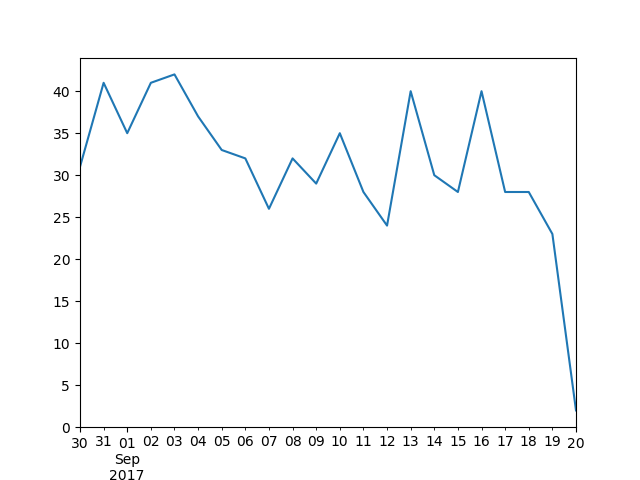

In [82]:
pylab.figure()
data.groupby(pandas.TimeGrouper(key="Visit Date", freq="1D")
            ).count()["Visit Type"].plot()

## Matplotlib

* Matplotlib (https://matplotlib.org/) is a python plotting package
* Can render in the notebook or save as jpg/png/...
* Provides a log of options for formatting plots

<IPython.core.display.Javascript object>


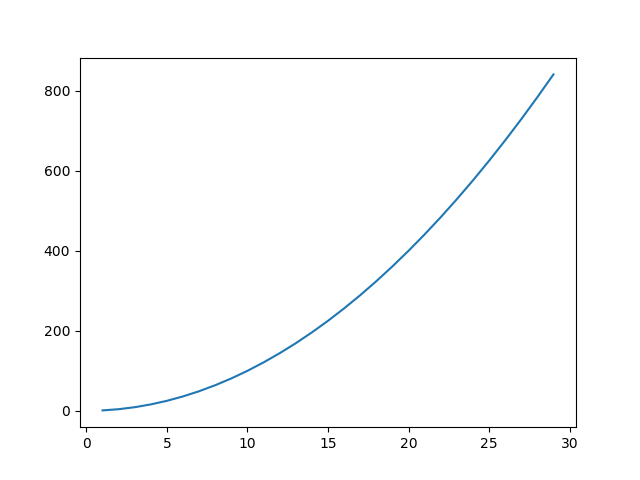

In [68]:
from matplotlib import pylab

x = list(range(1, 30))
y = [i ** 2 for i in x]
z = [i ** 1.7 for i in x]
pylab.figure()
pylab.plot(x, y)
pylab.show()

<IPython.core.display.Javascript object>


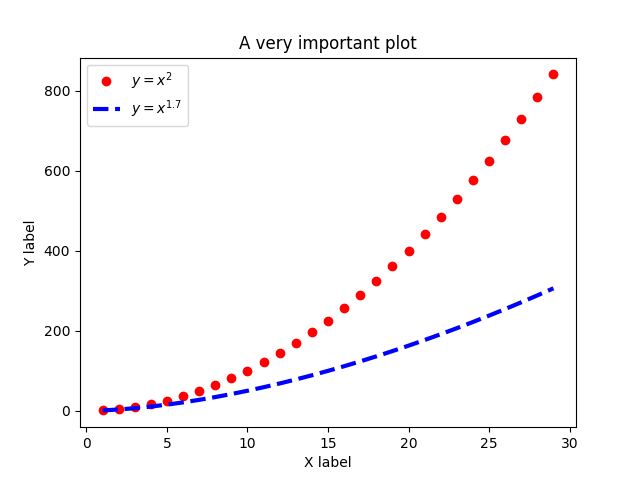

In [83]:
pylab.figure()
pylab.plot(x, y, "ro", label=r"$y=x^2$")
pylab.plot(x, z, "b--", label=r"$y=x^{1.7}$", lw=3)
pylab.xlabel("X label"); pylab.ylabel("Y label")
pylab.title("A very important plot")
pylab.legend()
pylab.show()

Now there are four excersies to try out: 

1. Analysing aggregated data from the API
2. Analysing logs of user activity
3. Analysing the time it takes from forms are submitted until alerts are sent
4. Analysing hypertension patient data